In [ ]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.python.ops import math_ops as tfmath_ops
from utils import Make_Video_batch, make_checkpoint_folder
from utils import build_video_batch_graph, plot_latents, MSE_rotation
from utils import pandas_res_saver
import sys
import time
import pickle
import os
from utils_circles_grid import Make_circles, Make_squares, plot_circle
from utils_circles_grid import plot_heatmap, plot_square
from GPVAEmodel import *

In [ ]:
default_base_dir = os.getcwd()

parser = argparse.ArgumentParser(description='Train GPP-VAE')
parser.add_argument('--steps', type=int, default=50000, help='Number of steps of Adam')
parser.add_argument('--beta0', type=float, default=1, help='initial beta annealing value')
parser.add_argument('--elbo', type=str, choices=['SIN', 'NP'], default='SIN',
                     help='Structured Inf Nets ELBO or Neural Processes ELBO')
parser.add_argument('--modellt', type=float, default=5, help='time scale of model to fit to data')
parser.add_argument('--base_dir', type=str, default=default_base_dir, help='folder within a new dir is made for each run')
parser.add_argument('--expid', type=str, default="debug", help='give this experiment a name')
parser.add_argument('--ram', type=float, default=0.5, help='fraction of GPU ram to use')
parser.add_argument('--seed', type=int, default=None, help='seed for rng')

args = parser.parse_args([])

In [81]:
batch = 35
tmax = 30
px = 32
py = 32
r = 3
vid_lt = 5
model_lt = args.modellt


# batch = 1
# tmax = 30
# px = 16
# py = 16
# pz = 16
# r = 2
# vid_lt = 5
# model_lt = args.modellt

In [35]:
# beta = tf.compat.v1.placeholder(dtype=tf.float32, shape=())
# vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py, r=r, lt=vid_lt)
# s_elbo, s_rec, s_pkl, np_elbo, np_rec, np_pkl, \
#     p_m,p_v,q_m,q_v,pred_vid, _ = build_sin_and_np_elbo_graphs(vid_batch, beta, lt=model_lt)

In [36]:
vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py, r=r, lt=vid_lt)

In [37]:
vid_batch[0][0]

<tf.Tensor: id=60437, shape=(16, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 

In [38]:
vid_batch[0][1]

<tf.Tensor: id=60446, shape=(16, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 

In [31]:
vid_batch[0][2]

<tf.Tensor: id=59662, shape=(16, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [32]:
vid_batch[0][3]

<tf.Tensor: id=59671, shape=(16, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [33]:
vid_batch[0][4]

<tf.Tensor: id=59680, shape=(16, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [71]:
px = py = pz = 12
vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py, r=2, lt=vid_lt)
vid_batch[0][11]
# z,x,y = vid_batch[0][11].numpy().nonzero()
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, -z, zdir='z', c= 'red')
# plt.savefig("demo.png")

<tf.Tensor: id=67732, shape=(12, 12), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

/Users/bhupendra/anaconda3/envs/gpvae1/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


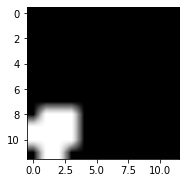

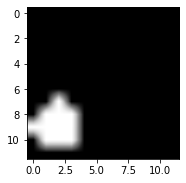

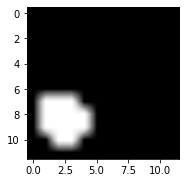

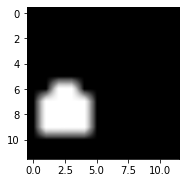

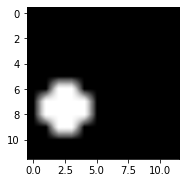

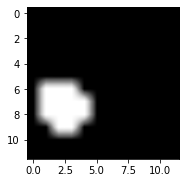

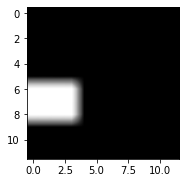

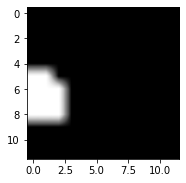

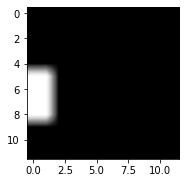

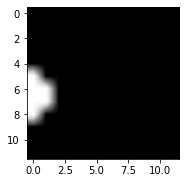

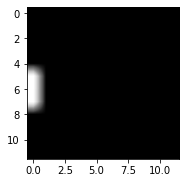

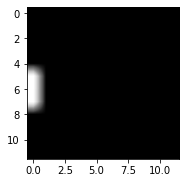

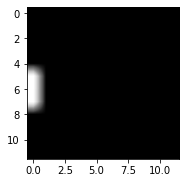

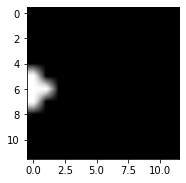

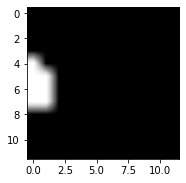

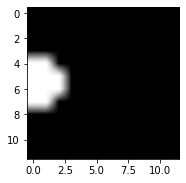

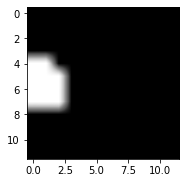

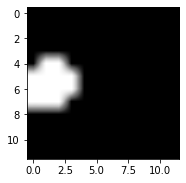

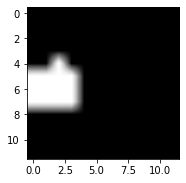

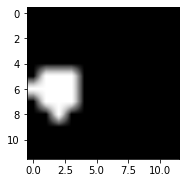

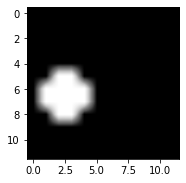

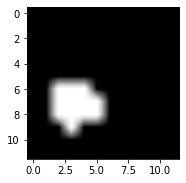

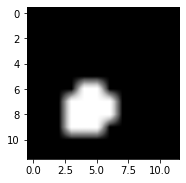

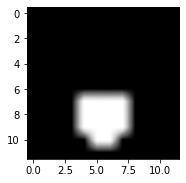

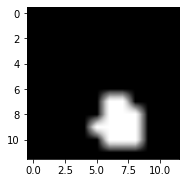

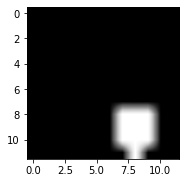

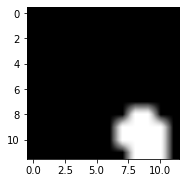

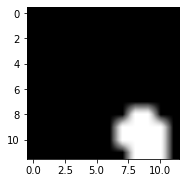

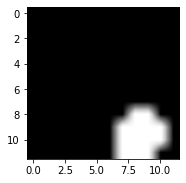

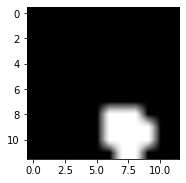

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Make an array with ones in the shape of an 'X'
a = np.eye(10,10)
a += a[::-1,:]

for i in range(30):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    # Bilinear interpolation - this will look blurry
#     d = np.random.randint(0, 2, size=(3,3,3))
#     ax1.imshow(d, interpolation='bilinear', cmap=cm.Greys_r)
    ax1.imshow(vid_batch[0][i], interpolation='bilinear', cmap=cm.Greys_r)

# ax2 = fig.add_subplot(122)
# # 'nearest' interpolation - faithful but blocky
# ax2.imshow(a, interpolation='nearest', cmap=cm.Greys_r)

plt.show()

In [52]:
d = np.random.randint(0, 2, size=(3,3,3))

In [55]:
ax1.imshow(d, interpolation='bilinear', cmap=cm.Greys_r)
plt.show()

In [67]:
vid_batch[0][0]

<tf.Tensor: id=66165, shape=(12, 12), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [82]:
make_batch = lambda s: Make_Video_batch(tmax=tmax, px=px, py=py, lt=vid_lt, batch=batch, seed=s, r=r)
Test_Batches = [make_batch(s) for s in range(10)]

In [85]:
Test_Batches[0][0].shape

(35, 30, 2)

In [86]:
Test_Batches[0][1].shape

(35, 30, 32, 32)